# Wil Bishop
# IE 3013 Final Project
# Recommender System for Goodreads Based on User-to-User Collaborative Filtering
The authors of the dataset I'm using have asked me to include this information:

Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in RecSys'18.

Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", in ACL'19.

That database is "goodreads_interactions.csv" which can be found at the following address: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/shelves

# Topic Description

The purpose of this project is to find content to recommend to each of a service's users. In this specific example we are using Goodreads and therefore are recommending books. For simplicity's sake, we aim only to recommend one book to each of the users.

The problem is that we obviously don't have the user's ratings for content which is to be recommended, as they haven't consumed it yet! Why would you recommend someone a book that they had already read? So we need to use data from their previous ratings to predict what they would've rated all of the books in the database, and then choose the book in the database that they would've rated the highest, and recommend that book to them.

The way we go about this is by finding other user's who HAVE rated the book in question, and determine how similar those users are to the user we're focusing on getting a recommendation for. We want to find someone who has rated the book and also has a high similarity to the user in question.

Our method for getting this information will be to find a centered Pearson correlation coefficient, which involves finding the cosine similarity of two vectors.

### Part One

This data file was very large at 4GB and caused almost comically, impossibly long loading times, therefore I decided only include the first 500,000 rows, and also to include only the three relevant columns: user_id, book_id, and rating.

I have commented out this code because it takes so long to reproduce the results.

In [65]:
using CSV
using DataFrames

#df = CSV.read("goodreads_interactions.csv", DataFrame)
#df = df[1:500000, :]
#CSV.write("ProjectData.csv", df)
# df = CSV.read("ProjectData.csv", DataFrame)
# relevant = df[:, [1,2,4]]
# CSV.write("relevant.csv", relevant)

### Part Two

Now I have created a matrix that is 1000x34460, with 1000 users and 34460 books. All of the data inside the matrix are the review scores that a user assigned to a specific book.

For simplicity, I have initially set the default rating to -1. Since it is impossible to leave a -1 review on Goodreads, this will help me easily filter out those spaces which do not have actual reviews in them. This is important because we want to center our review scores around 0. To do that, we take the average of the real review scores, and then subtract every real review score by that average. After that, we can change the -1's to 0's. We don't want to start with them as 0's, because someone could've rated a book 0 for real, and we'd have no way to tell the placeholders apart from authentic data.

This way of centering the data makes sure that optimistic and pessimistic raters are equally weighted. So if someone usually rates 3/5, and someone usually rates 4/5, both of those people's reviews will be based on the deviation from their average review, or whether they reviewed it more or less positively than their average review.

In [70]:
relevant = CSV.read("relevant.csv",DataFrame)
matr = fill(-1.0, 1000, 34460)
for k in 1:500000
    if relevant[k, 1] <= 999 && relevant[k, 2] <= 34459
        matr[(relevant[k, 1]+1), (relevant[k, 2]+1)] = relevant[k, 3]
    end
end
CSV.write("matr_before.csv", Tables.table(matr))
for i in 1:1000
    row_average = 0
    total_in_row = 0
    for j in 1:1000
        if matr[i, j] != -1
            row_average += matr[i, j]
            total_in_row += 1
        end
    end
    for j in 1:1000
        if matr[i,j] != -1
            matr[i, j] -= (row_average / total_in_row)
        else
            matr[i, j] = 0
        end
    end
end
CSV.write("matr.csv", Tables.table(matr))

"matr.csv"

# Graphs

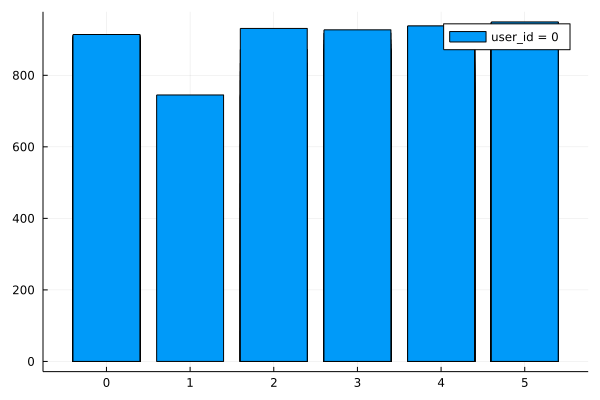

In [124]:
using Plots

values = CSV.read("matr_before.csv", DataFrame)
values_mat = Matrix(values)

real_values = []
for i in 1:34460
    if values_mat[1,i] != -1
        append!(real_values,values_mat[1,i])
    end
end
#only 949 of the 34460 values are authentic data
#print(length(real_values))
bar(real_values, 1:949, label="user_id = 0")

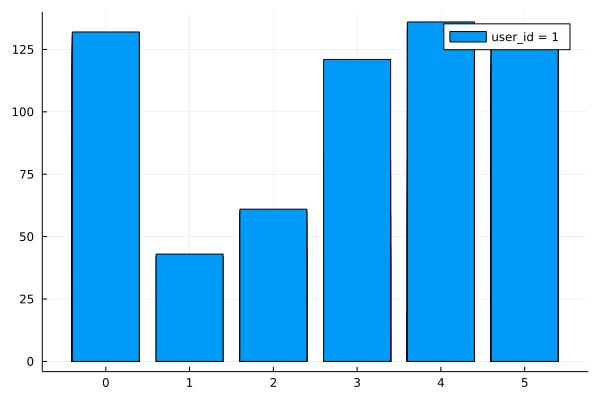

In [125]:
real_values = []
for i in 1:34460
    if values_mat[2,i] != -1
        append!(real_values,values_mat[2,i])
    end
end
#only 136 real values
#print(length(real_values))
bar(real_values, 1:136, label="user_id = 1")

### Part Three

Now we actually have the data that we'll be working with.

We will now create a matrix of similarities using cosine. Since there are 1000 users, there will be 1000 rows and 1000 columns of this matrix. (a,a) will obviously always be 1.

In [95]:
using CSV
using DataFrames

df = CSV.read("matr.csv",DataFrame)
data = Matrix(df)
function cosine_similarity(vector1, vector2)
    result = sum(vector1.*vector2)/(sqrt(sum(vector1.^2)) * sqrt(sum(vector2.^2)))
    return(result)
end
similarity = zeros(1000, 1000)
for i in 1:1000
    for j in 1:1000
        similarity[i,j] = cosine_similarity(data[i,:],data[j,:])
    end
end
CSV.write("similarity_matrix.csv", Tables.table(similarity))

"similarity_matrix.csv"

### Part Four

We will now define the neighborhood of most similar vectors to be those which exhibit >90% cosine similarity. To find the prediction of a value in "vector a" at "index a" (predict_val) we will take the sum of the similarity between "vector a" and "vector b" (sim_val) multiplied by the value of "index a" in "vector b" (actual_val). We will then divide this sum by the sum of the similarity between "vector a" and "vector b" (sim_val).

We set already-known data to -100 so that the system will not recommend anything that the person has already rated.

In [77]:
data_before = CSV.read("matr_before.csv",DataFrame)
data = CSV.read("matr.csv", DataFrame)
data_mat = Matrix(data)
data_before_mat = Matrix(data_before)
for i in 1:1000
    for k in 1:1000
        if data_before_mat[i,k] == -1
            first_sum = 0
            second_sum = 0
            for j in 1:1000
                if similarity[i, j] >= .9
                    first_sum += similarity[i, j] * data_mat[i, j]
                    second_sum += similarity[i, j]
                end
            end
            data_mat[i,k] = first_sum / second_sum
        else
            data_mat[i,k] = -100
        end
    end
end
CSV.write("data_with_predictions.csv", Tables.table(data_mat))

"data_with_predictions.csv"

### Part Five

Now to get recommendations you simply sort each row from highest to lowest. You'll get the most recommended content at the front of the queue. You'll of course have to keep track of the positions of each of these values so that you know the corresponding book_id.

Here we'll compile just the top recommendation for every user.

Also, every book is one off of its index. In the beginning, the Goodreads data was indexed started at 0, but Julia indexes starting at 1. So we subtract by 1 to get the correct book number to recommend.

In [3]:
using CSV
using DataFrames

df = CSV.read("data_with_predictions.csv",DataFrame)
data = Matrix(df)
list_of_recommendations = fill(0, 1000, 1)
for i in 1:1000
    list_of_recommendations[i,1] = ((findall(data[i,:] .== maximum(data[i,:]))[1]) - 1)
end
print(list_of_recommendations)

[1000; 1001; 1003; 1004; 1471; 1283; 1072; 1386; 1002; 1387; 7592; 1107; 1000; 1004; 1004; 1012; 1188; 1402; 1002; 1555; 5903; 13619; 1007; 1402; 1016; 6410; 1000; 5526; 1000; 1039; 1029; 7352; 1188; 1013; 1086; 1003; 1574; 1003; 1003; 1048; 1000; 1004; 1197; 1003; 1000; 1340; 6229; 5463; 13005; 1012; 1013; 1002; 1013; 5812; 1113; 1217; 1088; 1233; 1000; 1473; 1000; 1203; 21056; 1387; 1188; 1007; 1041; 1041; 1188; 1000; 8041; 1248; 1000; 1010; 1003; 1473; 21055; 7299; 1012; 1002; 1200; 1012; 1387; 1473; 1002; 1002; 1434; 1007; 1210; 1203; 1005; 1002; 1611; 26425; 18272; 1386; 1018; 1012; 7457; 1203; 1000; 5770; 1016; 7333; 7318; 1010; 1473; 1218; 1012; 1041; 1012; 7135; 1000; 1003; 1000; 1005; 13539; 17320; 15038; 1003; 1007; 1003; 1062; 1307; 1047; 1203; 0; 0; 1555; 1007; 1079; 6356; 1194; 1221; 1402; 1217; 1002; 1000; 2588; 1013; 1386; 1012; 1037; 1007; 1053; 1358; 7169; 4188; 1471; 1402; 1221; 1000; 1086; 2344; 1627; 1013; 1003; 1000; 1002; 5834; 1012; 1007; 2953; 1000; 1012; 1000; 

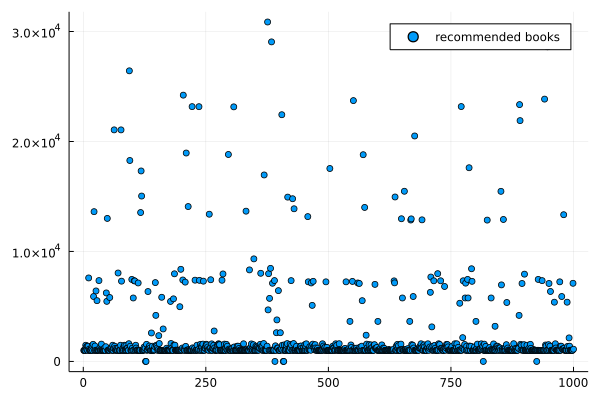

In [15]:
using Plots

scatter(1:1000, list_of_recommendations, label = "recommended books")

In [5]:
sum(list_of_recommendations)/1000

2445.703

# Conclusion

As you can see below, user_id 0 would get recommended book_id 1000, user_id 1 would get recommended book_id 1001, etc.

This data can then be linked up with another dataset, available by the same people at https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/books and called "goodreads_books.json.gz". 

Connecting the two datasets will let us look up the book numbers seen above and translate those numbers into the actual titles of the books. However, that file is quite large, so we shall leave the books as numbers for now.

One may notice by the graph and calculation above that the usual recommended book skews towards the 1000-3000 range. This is due to the smaller sample we used. We are measuring the first 1034 users of Goodreads. Many of the first users only had access to the first books that were on the site, and then forgot their password or something similar and didn't keep up with new releases. Also, it made sense for Goodreads to add popular books before less popular books, so those with smaller book_id's were either published at a similar time as Goodreads was started around 2006, or were already popular at that point.